In [1]:
import pandas as pd
import ray
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import plotly.graph_objects as go
from itertools import combinations
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import (train_test_split, GridSearchCV,
                                    StratifiedKFold, StratifiedShuffleSplit,
                                    cross_val_score)
from sklearn.metrics import make_scorer, recall_score, precision_score, f1_score, classification_report
from imblearn.ensemble import BalancedRandomForestClassifier
import numpy as np

2023-10-16 12:18:27.779351: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-16 12:18:27.822170: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-16 12:18:27.822196: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-16 12:18:27.822220: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-16 12:18:27.828862: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-16 12:18:27.830371: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [2]:

def Table_variable_type_N(df_id,df,N,types,
                          title='Variable Stars',
                         x_label='Type of Variability',
                         y_label='N'):
    table = df.groupby(types).count().sort_values(by=df_id,ascending=False)[[df_id]]
    name = table.head(N).index
    value = table.head(N)[df_id].values

    # Crear el gráfico de barras utilizando Seaborn
    plt.figure(figsize=(15, 8))  # Añadir tamaño de figura
    sns.barplot(x=name, y=value)

    # Personalizar el gráfico
    plt.xlabel(x_label, fontsize=20)
    plt.ylabel(y_label, fontsize=20)

    # Aumentar el tamaño de los ticks
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

    # Mostrar el gráfico
    plt.show()
    return table

In [3]:
import pandas as pd

def preprocess_features(data):
    """
    Realiza el preprocesamiento de las características especificadas.

    Args:
    - data (pd.DataFrame): DataFrame original con los datos.

    Returns:
    - data (pd.DataFrame): DataFrame procesado con características adicionales y filas inválidas eliminadas.
    """
    
    # Lista de filtros SPLUS
    splus_filters = ['mag_psf_u', 'mag_psf_J0378', 'mag_psf_J0395', 'mag_psf_J0410',
                    'mag_psf_J0430', 'mag_psf_g', 'mag_psf_J0515', 'mag_psf_r',
                    'mag_psf_J0660', 'mag_psf_i', 'mag_psf_J0861', 'mag_psf_z']
    
    # Busca valores 999 o -999 en las columnas especificadas
    invalid_values = data[splus_filters].isin([999, -999]).sum()

    # Filtra y muestra solo las columnas que tienen estos valores inválidos
    columns_with_invalids = invalid_values[invalid_values > 0]

    if columns_with_invalids.empty:
        print("Todas las columnas tienen datos válidos, sin valores 999 o -999.")
    else:
        print(f"Las siguientes columnas tienen valores 999 o -999:\n{columns_with_invalids}")

    # Filtra el DataFrame para excluir filas con valores 999 o -999 en las columnas especificadas
    data = data[~data[splus_filters].isin([999, -999]).any(axis=1)].reset_index(drop=True)

    # Combinaciones de características para crear características adicionales
    combinations = ['mag_psf_u-mag_psf_J0378', 'mag_psf_u-mag_psf_g',
       'mag_psf_u-mag_psf_J0430', 'mag_psf_u-mag_psf_J0410',
       'mag_psf_J0378-mag_psf_z', 'mag_psf_J0378-mag_psf_J0430',
       'mag_psf_u-mag_psf_i', 'mag_psf_J0378-mag_psf_J0861',
       'mag_psf_J0378-mag_psf_J0410', 'mag_psf_u-mag_psf_z',
       'mag_psf_u-mag_psf_J0515', 'mag_psf_u-mag_psf_r',
       'mag_psf_J0378-mag_psf_g', 'mag_psf_J0378-mag_psf_i',
       'mag_psf_u-mag_psf_J0861', 'mag_psf_J0430-mag_psf_z',
       'mag_psf_J0395-mag_psf_z', 'mag_psf_J0410-mag_psf_z',
       'mag_psf_J0378-mag_psf_r', 'mag_psf_J0378-mag_psf_J0515',
       'mag_psf_g-mag_psf_z']

    for combo in combinations:
        col1, col2 = combo.split('-')
        data[combo] = data[col1] - data[col2]

    return data

In [4]:
def optimize_hyperparameters(X, y):
    # Initialize a BalancedRandomForestClassifier
    clf = BalancedRandomForestClassifier()

    # Define hyperparameters grid
    param_grid = {
        'n_estimators': [200,500,800],
        'max_features': ['sqrt', 'log2'],
        'max_depth': [10, 20, 30, None],
        'sampling_strategy': ['majority', 'not minority', 'not majority', 'all', 'auto']
    }

    # Set up k-fold cross-validation
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Macro-recall scorer
    macro_recall = make_scorer(recall_score, average='macro')

    # Grid search with cross-validation
    grid_search = GridSearchCV(clf, param_grid, cv=kfold, scoring=macro_recall,n_jobs=-1, verbose=1)
    grid_search.fit(X, y)

    # Return best parameters and best score
    return grid_search

In [88]:
import pandas as pd

def compute_importance(df):
    # Creamos un nuevo dataframe para guardar las importancias acumuladas
    summed_importance = pd.DataFrame(columns=['filtro', 'importancia'])

    # Iteramos sobre cada fila en el dataframe original
    for index, row in df.iterrows():
        filtro = row['filtro']
        importancia = row['importancia']

        # Si encontramos un guion, significa que es una combinación
        if '-' in filtro:
            feature1, feature2 = filtro.split('-')

            # Sumamos la importancia a ambos features
            if feature1 not in summed_importance['filtro'].values:
                new_row = pd.DataFrame({'filtro': [feature1], 'importancia': [importancia]})
                summed_importance = pd.concat([summed_importance, new_row], ignore_index=True)
            else:
                summed_importance.loc[summed_importance['filtro'] == feature1, 'importancia'] += importancia
            
            if feature2 not in summed_importance['filtro'].values:
                new_row = pd.DataFrame({'filtro': [feature2], 'importancia': [importancia]})
                summed_importance = pd.concat([summed_importance, new_row], ignore_index=True)
            else:
                summed_importance.loc[summed_importance['filtro'] == feature2, 'importancia'] += importancia
        else:
            # Si no es una combinación, simplemente agregamos o sumamos la importancia
            if filtro not in summed_importance['filtro'].values:
                new_row = pd.DataFrame({'filtro': [filtro], 'importancia': [importancia]})
                summed_importance = pd.concat([summed_importance, new_row], ignore_index=True)
            else:
                summed_importance.loc[summed_importance['filtro'] == filtro, 'importancia'] += importancia
                
    return summed_importance


\begin{tabular}{llr}
\toprule
 & filtro & importancia \\
\midrule
0 & mag_psf_u & 0.326688 \\
1 & mag_psf_J0378 & 0.262642 \\
2 & mag_psf_g & 0.148503 \\
3 & mag_psf_J0430 & 0.149398 \\
4 & mag_psf_J0410 & 0.129244 \\
5 & mag_psf_z & 0.171825 \\
6 & mag_psf_i & 0.119982 \\
7 & mag_psf_J0861 & 0.125684 \\
8 & mag_psf_J0515 & 0.113943 \\
9 & mag_psf_r & 0.100329 \\
10 & mag_psf_J0395 & 0.116188 \\
11 & mag_psf_J0660 & 0.086642 \\
\bottomrule
\end{tabular}



In [ ]:
def Table_variable_type_N(df_id, df1, df2, N, types,
                          title='Variable Stars',
                          x_label='Type of Variability',
                          y_label='N'):

    colors = plt.cm.viridis(np.linspace(0, 1, 3))
    # Agrupa y cuenta los valores para cada dataframe
    table1 = df1.groupby(types).count().sort_values(by=df_id, ascending=False)[[df_id]]
    table2 = df2.groupby(types).count().sort_values(by=df_id, ascending=False)[[df_id]]

    # Combina las tablas en una sola
    combined = pd.concat([table1, table2], axis=1, keys=["df1", "df2"])
    combined.fillna(0, inplace=True)

    # Ordena la tabla combinada y toma los N primeros valores
    combined_sorted = combined.sort_values(by=('df1', df_id), ascending=False).head(N)

    names = combined_sorted.index
    values1 = combined_sorted["df1"][df_id].values
    values2 = combined_sorted["df2"][df_id].values

    # Crear el gráfico de barras utilizando Matplotlib
    plt.figure(figsize=(15, 8))
    
    # Crear barras solo con contorno para las barras verdes
    plt.bar(names, values2, label='GaiaVarWithFullSplusObs',color=colors[1], hatch='-')
    # Barras rellenas para las amarillas
    plt.bar(names, values1, label='HighConfidenceObjects',color=colors[2], hatch='/')

    # Personalizar el gráfico
    plt.xlabel(x_label, fontsize=25)
    plt.ylabel(y_label, fontsize=25)
    plt.yticks(fontsize=25)
    plt.xticks(fontsize=25)
    plt.xticks(rotation=45,fontsize=25)
    plt.legend()
    plt.legend(prop={'size': 25})
    plt.savefig("bar_plot_class.pdf", format='pdf', bbox_inches='tight')

    # Mostrar el gráfico
    plt.show()
    return combined_sorted

In [117]:
gaia_splus_predicted = pd.read_csv('gaia_splus_predicted.csv')

In [5]:
gaia_splus = pd.read_csv("../../SplusData/splus_gaia_variable.csv",delimiter=",")

In [6]:
from astropy import units as u
from astropy.coordinates import SkyCoord
# Crear un objeto SkyCoord con las coordenadas RA/Dec
coord = SkyCoord(ra=gaia_splus['Ra_1'].values*u.degree, dec=gaia_splus['Dec_1'].values*u.degree, frame='icrs')  # ICRS es el sistema estándar para RA/Dec

# Transformar a coordenadas galácticas
galactic = coord.galactic
gaia_splus['l'] = galactic.l.degree
gaia_splus['b'] = galactic.b.degree

In [29]:
x = gaia_splus['Ra_1']
y = gaia_splus['Dec_1']

In [8]:
unique = gaia_splus.loc[gaia_splus['GroupID'].notna()].sort_values(by='best_class_score',ascending=False).drop_duplicates(subset=['GroupID'])

In [9]:
gaia_splus = pd.concat([gaia_splus.loc[gaia_splus['GroupID'].isna()],unique]).reset_index(drop=True)

In [10]:
gaia_splus = preprocess_features(gaia_splus)

Las siguientes columnas tienen valores 999 o -999:
mag_psf_u        17374
mag_psf_J0378    11237
mag_psf_J0395    23846
mag_psf_J0410     4981
mag_psf_J0430     4065
mag_psf_g         1429
mag_psf_J0515     1134
mag_psf_r         3788
mag_psf_J0660     1692
mag_psf_i         9496
mag_psf_J0861     2602
mag_psf_z         5272
dtype: int64


In [32]:
x_con_todas_obs = gaia_splus['Ra_1']
y_con_todas_obs = gaia_splus['Dec_1']

In [33]:
filters_mag = ['mag_psf_u', 'mag_psf_J0378', 'mag_psf_J0395', 'mag_psf_J0410',
                    'mag_psf_J0430', 'mag_psf_g', 'mag_psf_J0515', 'mag_psf_r',
                    'mag_psf_J0660', 'mag_psf_i', 'mag_psf_J0861', 'mag_psf_z']
scaler = StandardScaler()
gaia_splus[filters_mag] = scaler.fit_transform(gaia_splus[filters_mag])

In [34]:
gaia_splus = preprocess_features(gaia_splus)

Todas las columnas tienen datos válidos, sin valores 999 o -999.


In [35]:
#table = Table_variable_type_N("splus_oid_1",gaia_splus,10,"best_class_name")

In [232]:
mag_features = gaia_splus[filters_mag]
df_rf = gaia_splus[["splus_oid_1","best_class_name","best_class_score",'Ra_1','Dec_1'] + filters_mag].reset_index(drop=True)
for v in combinations(mag_features, 2):
    df_rf[f"{v[0]}-{v[1]}"] = gaia_splus[v[0]] - gaia_splus[v[1]]

In [309]:
p = 0.9
n = 5

In [310]:
df_rf = df_rf.loc[(df_rf['best_class_name']!='S')&(df_rf['best_class_name']!='SOLAR_LIKE')]

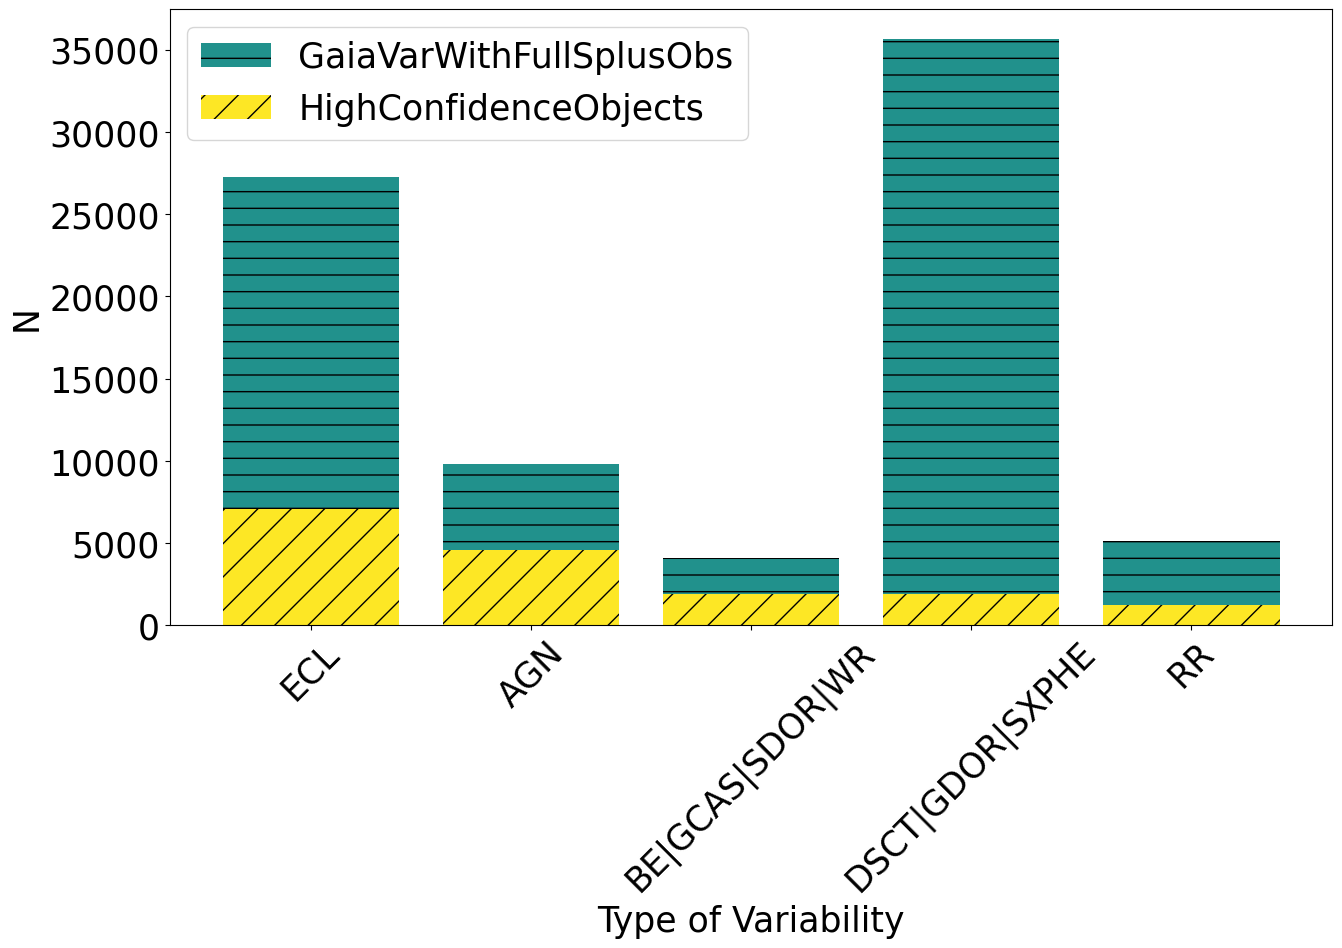

In [311]:
table = Table_variable_type_N("splus_oid_1", 
                              df_rf.loc[df_rf["best_class_score"] > p], 
                              df_rf.loc[df_rf["best_class_score"] <= p], 
                              n, 
                              "best_class_name")

In [313]:
df_rf = df_rf.loc[(df_rf["best_class_score"]>p)&
                  (df_rf["best_class_name"].isin(table.head(n).index))]

In [40]:
le = LabelEncoder()
df_rf['label'] = le.fit_transform(df_rf['best_class_name'])

In [41]:
df_rf = df_rf.loc[(df_rf['best_class_name']!='S')&(df_rf['best_class_name']!='SOLAR_LIKE')]

In [42]:
df_rf.groupby('best_class_name').count()

splus_oid_1  best_class_score  Ra_1  Dec_1  mag_psf_u  \
best_class_name                                                          
AGN                     4559              4559  4559   4559       4559   
BE|GCAS|SDOR|WR         1906              1906  1906   1906       1906   
DSCT|GDOR|SXPHE         1883              1883  1883   1883       1883   
ECL                     7090              7090  7090   7090       7090   
RR                      1245              1245  1245   1245       1245   

                 mag_psf_J0378  mag_psf_J0395  mag_psf_J0410  mag_psf_J0430  \
best_class_name                                                               
AGN                       4559           4559           4559           4559   
BE|GCAS|SDOR|WR           1906           1906           1906           1906   
DSCT|GDOR|SXPHE           1883           1883           1883           1883   
ECL                       7090           7090           7090           7090   
RR                        1245           1245           1245           1245   

                 mag_psf_g  ...  mag_psf_r-mag_psf_i  mag_psf_r-mag_psf_J0861  \
best_class_name             ...                                                 
AGN                   4559  ...                 4559                     4559   
BE|GCAS|SDOR|WR       1906  ...                 1906                     1906   
DSCT|GDOR|SXPHE       1883  ...                 1883                     1883   
ECL                   7090  ...                 7090                     7090   
RR                    1245  ...                 1245                     1245   

                 mag_psf_r-mag_psf_z  mag_psf_J0660-mag_psf_i  \
best_class_name                                                 
AGN                             4559                     4559   
BE|GCAS|SDOR|WR                 1906                     1906   
DSCT|GDOR|SXPHE                 1883                     1883   
ECL                             7090                     7090   
RR                              1245                     1245   

                 mag_psf_J0660-mag_psf_J0861  mag_psf_J0660-mag_psf_z  \
best_class_name                                                         
AGN                                     4559                     4559   
BE|GCAS|SDOR|WR                         1906                     1906   
DSCT|GDOR|SXPHE                         1883                     1883   
ECL                                     7090                     7090   
RR                                      1245                     1245   

                 mag_psf_i-mag_psf_J0861  mag_psf_i-mag_psf_z  \
best_class_name                                                 
AGN                                 4559                 4559   
BE|GCAS|SDOR|WR                     1906                 1906   
DSCT|GDOR|SXPHE                     1883                 1883   
ECL                                 7090                 7090   
RR                                  1245                 1245   

                 mag_psf_J0861-mag_psf_z  label  
best_class_name                                  
AGN                                 4559   4559  
BE|GCAS|SDOR|WR                     1906   1906  
DSCT|GDOR|SXPHE                     1883   1883  
ECL                                 7090   7090  
RR                                  1245   1245  

[5 rows x 83 columns]

In [47]:
x_p_09 = df_rf['Ra_1']
y_p_09 = df_rf['Dec_1']

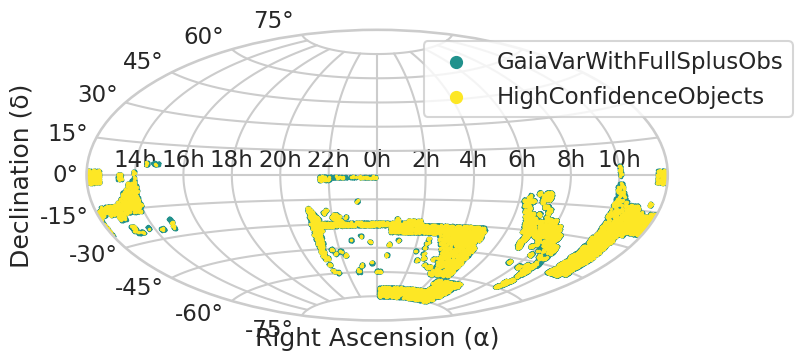

In [359]:
import matplotlib.pyplot as plt
import numpy as np

# Función para convertir las coordenadas a radianes y ajustar el rango de l
def convert_coordinates(ra, dec):
    ra_rad = np.radians(ra)
    dec_rad = np.radians(dec)
    ra_rad = np.mod(ra_rad + np.pi, 2. * np.pi) - np.pi
    return ra_rad, dec_rad

# Convertir las coordenadas para cada conjunto de datos
ra_rad, dec_rad = convert_coordinates(x, y)
ra_con_todas_obs_rad, dec_con_todas_obs_rad = convert_coordinates(x_con_todas_obs, y_con_todas_obs)
ra_p_09_rad, dec_p_09_rad = convert_coordinates(x_p_09, y_p_09)

# Crear un plot con proyección 'mollweide'
fig = plt.figure(figsize=(7.5, 5))
ax = fig.add_subplot(111, projection="aitoff")

# Usar viridis para diferenciar entre los conjuntos de datos
colors = plt.cm.viridis(np.linspace(0, 1, 3))

# Graficar las coordenadas para cada conjunto
ax.scatter(ra_con_todas_obs_rad, dec_con_todas_obs_rad, s=1, c=[colors[1]], label='GaiaVarWithFullSplusObs')
ax.scatter(ra_p_09_rad, dec_p_09_rad, s=1, c=[colors[2]], label='HighConfidenceObjects')

# Configurar las etiquetas, el grid y la leyenda
hours = ['10h', '8h', '6h', '4h', '2h', '0h', '22h', '20h', '18h', '16h', '14h']
degrees_from_hours = [150, 120, 90, 60, 30, 0, -30, -60, -90, -120, -150]
ax.set_xticks(np.radians(degrees_from_hours))
ax.set_xticklabels(hours)

ax.set_xlabel('Right Ascension (α)')
ax.set_ylabel('Declination (δ)')
ax.grid(True)
ax.legend(markerscale=8, loc=(0.58, 0.7))
plt.savefig("Distribution.pdf", format='pdf', bbox_inches='tight')
plt.show()


In [39]:
X = df_rf.drop(['best_class_name',"splus_oid_1","best_class_score","label"], axis=1)
y = df_rf['label']

In [41]:
grid_search =  optimize_hyperparameters(X, y)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


/home/marcelo/anaconda3/envs/splus/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [42]:
best_params, best_score = grid_search.best_params_, grid_search.best_score_

In [44]:
feature_importances = grid_search.best_estimator_.feature_importances_
features = X.columns
sorted_features = sorted(zip(features, feature_importances), key=lambda x: x[1], reverse=True)


In [46]:
best_model = grid_search.best_estimator_

In [47]:
features = [t[0] for t in sorted_features]

In [48]:
pd.DataFrame(sorted_features).to_csv('sorted_features.csv',index=False)

In [49]:
pd.DataFrame([grid_search.best_params_]).to_csv('best_parameters.csv',index=False)

In [225]:


# Iniciar Ray
ray.init()

@ray.remote
def cross_val_n(best_params, X, y):
    sss = StratifiedShuffleSplit(n_splits=20, test_size=0.2, random_state=42)

    iteration = 0
    result = []
    for train_index, test_index in sss.split(X, y):
        iteration += 1
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        best_brfc = BalancedRandomForestClassifier(**best_params)
        best_brfc.fit(X_train, y_train)
        y_pred = best_brfc.predict(X_test)
        macro = recall_score(y_test, y_pred, average='macro')
        result.append(macro)
    return result

@ray.remote
def optimize_nfeatures(i, sorted_features, df_rf, best_params):
    if i ==0:
        X = df_rf.drop(['best_class_name','l','b', "splus_oid_1", "best_class_score", "label"], axis=1)
    else:
        X = df_rf.drop(['best_class_name','l','b', "splus_oid_1", "best_class_score", "label"] + sorted_features[-i:len(sorted_features)], axis=1)
    y = df_rf['label']
    
    # Llamar a cross_val_n de manera remota
    future = cross_val_n.remote(best_params, X, y)
    scores = ray.get(future)
    
    return scores



2023-10-15 16:56:44,776	INFO worker.py:1642 -- Started a local Ray instance.


In [224]:
ray.shutdown()

In [226]:
result = optimize_nfeatures.remote(0,list(sorted_features['0'].values),df_rf,best_parameters.iloc[0].to_dict())

In [230]:
first_acc = ray.get(result)

In [ ]:
# Llamando la función de forma paralela usando Ray
futures = [optimize_nfeatures.remote(i, sorted_features, df_rf, best_parameters) for i in range(len(sorted_features))]
scores_results = ray.get(futures)

# Finalizar Ray
ray.shutdown()

In [54]:
df_score_results = pd.DataFrame(np.array(scores_results))
df_score_results['mean']= df_score_results.mean(axis=1)
df_score_results['std']= df_score_results.std(axis=1)
df_score_results.to_csv('df_score_results.csv',index=False)

In [68]:
sorted_features = pd.read_csv('sorted_features.csv')
best_parameters = pd.read_csv('best_parameters.csv')
df_score_results = pd.read_csv('df_score_results.csv')

In [ ]:
Hyper_parameters = pd.DataFrame({
        'n_estimators': [[200,500,800]],
        'max_features': [['sqrt', 'log2']],
        'max_depth': [[10, 20, 30, None]],
        'sampling_strategy': [['majority', 'not minority', 'not majority', 'all', 'auto']]
    }
).T

Hyper_parameters['Best'] = best_parameters.T[0]

In [ ]:
# Usando la función
new_df = compute_importance(sorted_features)
print(new_df.to_latex())

In [274]:
df_aux = pd.DataFrame([first_acc])
df_aux['mean']= df_aux.mean(axis=1)
df_aux['std']= df_aux.std(axis=1)

In [299]:
x = range(0,len(features))
y = np.concatenate((df_aux['mean'].values,df_score_results['mean'].values))
y_err = np.concatenate((df_aux['std'].values,df_score_results['std'].values))

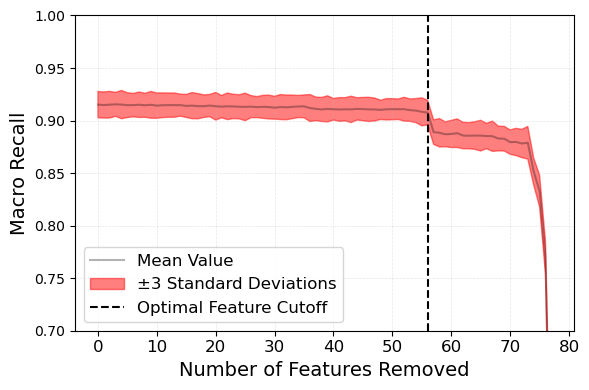

In [315]:
import matplotlib.pyplot as plt

# Ajustar el tamaño del gráfico
plt.figure(figsize=(6, 4))

# Crear el plot
plt.plot(x, y, color='black', alpha=0.3, label='Mean Value')  # Etiqueta actualizada para la línea continua
plt.fill_between(x, y - 3*y_err, y + 3*y_err, color='red', alpha=0.5, label='±3 Standard Deviations')  # Etiqueta actualizada para el área sombreada

# Etiquetas de los ejes con tamaños ajustados
plt.xlabel('Number of Features Removed', fontsize=14)
plt.ylabel('Macro Recall', fontsize=14)

# Tamaño de las marcas en los ejes
plt.xticks(fontsize=12)

# Agregar una línea vertical discontinua en x=60 y su correspondiente label para la leyenda
plt.axvline(x=56, linestyle='--', color='black', label='Optimal Feature Cutoff')

# Agregar la leyenda
plt.legend(fontsize=12, loc='lower left')

# Agregar una cuadrícula de fondo ligera
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.3)
plt.ylim(0.7, 1)

# Guardar el gráfico como PDF
plt.tight_layout()
plt.savefig('graph_for_paper.pdf', format='pdf')

# Mostrar el gráfico
plt.show()



In [304]:
n_features = len(sorted_features) - 56

In [322]:
array = np.zeros((5,5,20))

In [323]:
def C_M(label,predict_label):
    array = np.array(tf.math.confusion_matrix(label,predict_label) )
    df = pd.DataFrame(array)
    perc = df.copy()
    cols=perc.columns.values
    perc[cols]=perc[cols].div(perc[cols].sum(axis=1), axis=0).multiply(100)
    annot=df.round(2).astype(str) + "\n" + perc.round(1).astype(str) + "%"
    return array,annot

In [326]:
# Carga tu conjunto de datos
# Asumo que ya has cargado tu DataFrame como df_rf
results = []
X = df_rf[list(sorted_features.head(n_features)['0'].values)]
y = df_rf['label']

sss = StratifiedShuffleSplit(n_splits=20, test_size=0.2, random_state=42)

iteration = 0

for train_index, test_index in sss.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Ahora puedes entrenar tus modelos con estos conjuntos de entrenamiento y prueba.
    # Por ejemplo, imprimamos el número de la iteración y la distribución de las clases en el conjunto de prueba:
    print(f"Iteración {iteration}")
    print(y_test.value_counts(normalize=True))
    best_brfc = BalancedRandomForestClassifier(**best_parameters.iloc[0].to_dict())
    best_brfc.fit(X_train, y_train)
    y_pred = best_brfc.predict(X_test)

    # Calculate precision, recall, and F1 score for each class
    precision_per_class = precision_score(y_test, y_pred, average=None)
    recall_per_class = recall_score(y_test, y_pred, average=None)
    f1_per_class = f1_score(y_test, y_pred, average=None)
    array_2,_=C_M(y_test, y_pred)
    array[:,:,iteration] = array_2
    # Display results
    classes = list(set(y_test))
    for cls, precision, recall, f1 in zip(classes, precision_per_class, recall_per_class, f1_per_class):
        print(f"Class {cls}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")
        print("----------")
        results.append({
                    'Iteration': iteration,
                    'Class': cls,
                    'Precision': precision,
                    'Recall': recall,
                    'F1 Score': f1
                })
    iteration += 1





Iteración 0
label
3    0.424933
0    0.273299
1    0.114174
2    0.112976
4    0.074618
Name: proportion, dtype: float64


2023-10-15 18:42:59.155498: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-15 18:42:59.155920: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Class 0
Precision: 0.9782
Recall: 0.9825
F1 Score: 0.9803
----------
Class 1
Precision: 0.8200
Recall: 0.9685
F1 Score: 0.8881
----------
Class 2
Precision: 0.6467
Recall: 0.9178
F1 Score: 0.7588
----------
Class 3
Precision: 0.9644
Recall: 0.7652
F1 Score: 0.8533
----------
Class 4
Precision: 0.7267
Recall: 0.9076
F1 Score: 0.8071
----------
Iteración 1
label
3    0.424933
0    0.273299
1    0.114174
2    0.112976
4    0.074618
Name: proportion, dtype: float64
Class 0
Precision: 0.9826
Recall: 0.9901
F1 Score: 0.9863
----------
Class 1
Precision: 0.8512
Recall: 0.9606
F1 Score: 0.9026
----------
Class 2
Precision: 0.6579
Recall: 0.9337
F1 Score: 0.7719
----------
Class 3
Precision: 0.9615
Recall: 0.7750
F1 Score: 0.8583
----------
Class 4
Precision: 0.7355
Recall: 0.9157
F1 Score: 0.8157
----------
Iteración 2
label
3    0.424933
0    0.273299
1    0.114174
2    0.112976
4    0.074618
Name: proportion, dtype: float64
Class 0
Precision: 0.9771
Recall: 0.9814
F1 Score: 0.9792
----------

In [327]:
CM_array = array.mean(axis=2)
CM_std = array.std(axis=2)

In [ ]:
# Estilo y contexto de Seaborn
sns.set_style("whitegrid")
sns.set_context("talk")  # "talk" es más grande y adecuado para presentaciones. Otros contextos incluyen "paper", "notebook", y "poster".

# Tamaño de la figura
plt.figure(figsize=(12, 8))

# Crear el scatterplot
sns.scatterplot(data=df_rf, 
                x='mag_psf_u-mag_psf_J0378', 
                y='mag_psf_u', 
                hue='best_class_name', 
                s=10,  # Aumentar el tamaño de los puntos
                edgecolor='w',  # Añadir un borde blanco a los puntos
                linewidth=0)  # Grosor del borde

# Etiquetas y título
plt.ylabel('u', fontsize=25)
plt.xlabel('J0378-u', fontsize=25)
# Ajustar las etiquetas de los ticks
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

# Añadir leyenda
plt.legend(title='Class', title_fontsize='25', fontsize='20')
plt.savefig("color_color_diagram.pdf", format='pdf', bbox_inches='tight')

# Mostrar el gráfico
plt.show()

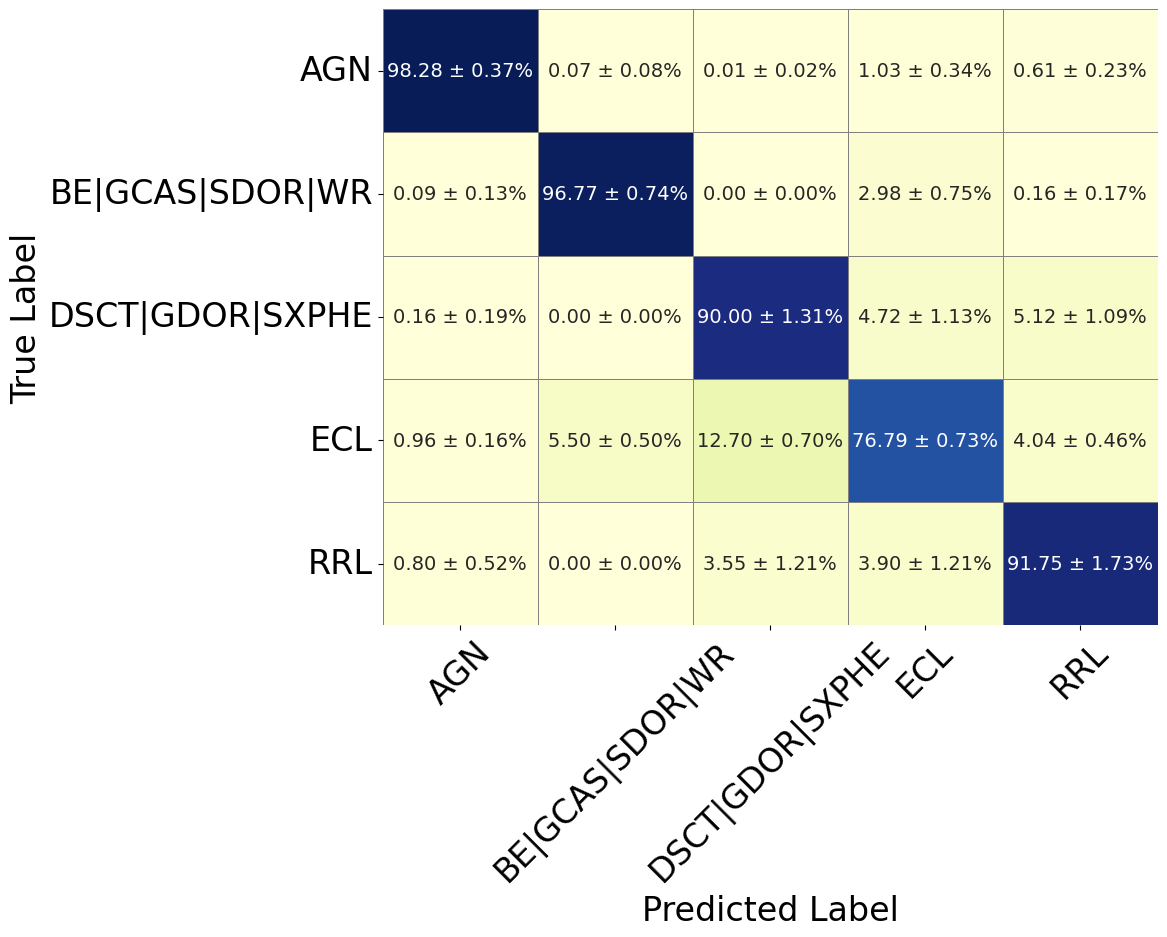

In [332]:
import seaborn as sns
import matplotlib.pyplot as plt
import math

# Calculate the scaling factor
factor = math.sqrt(10**2 + 8**2) / math.sqrt(6**2 + 4**2)

# Convertir la matriz de confusión a porcentaje
CM_percentage = CM_array / CM_array.sum(axis=1)[:, None] * 100
CM_std_percentage = CM_std / CM_array.sum(axis=1)[:, None] * 100

# Crear el plot
plt.figure(figsize=(10, 8))

# Labels para los ejes X e Y
labels = ["AGN", "BE|GCAS|SDOR|WR", "DSCT|GDOR|SXPHE", "ECL", "RRL"]

# Adjust the font size based on the scaling factor
base_fontsize = 14
adjusted_fontsize = int(base_fontsize * factor)

# Crear un array con las anotaciones que incluyen el error
annotations = np.array([
    [f"{CM_percentage[i, j]:.2f} ± {CM_std_percentage[i, j]:.2f}%" for j in range(CM_percentage.shape[1])]
    for i in range(CM_percentage.shape[0])
])

# Crear el heatmap
sns.heatmap(CM_percentage, annot=annotations, fmt="", cmap="YlGnBu", cbar=False,
            annot_kws={"size": 14}, linewidths=0.5, linecolor="gray",
            xticklabels=labels, yticklabels=labels)

# Configuración de las etiquetas
plt.ylabel('True Label', fontsize=adjusted_fontsize)
plt.xlabel('Predicted Label', fontsize=adjusted_fontsize)
plt.xticks(rotation=45, fontsize=adjusted_fontsize)  # Rotación de las etiquetas del eje X y ajuste del fontsize
plt.yticks(fontsize=adjusted_fontsize)

plt.savefig('Confusion_matrix.pdf', format='pdf', bbox_inches='tight')
plt.show()


In [96]:
def predict_and_map(gaia_data, feature_columns, model, labels):
    """
    Realiza una predicción con el modelo proporcionado y mapea los valores numéricos a etiquetas.

    Args:
    - gaia_data (pd.DataFrame): El DataFrame con los datos a predecir.
    - feature_columns (list): Lista de nombres de columnas de características a utilizar en la predicción.
    - model: El modelo de predicción.
    - labels (list): Lista de etiquetas para mapear las predicciones numéricas.

    Returns:
    - gaia_data (pd.DataFrame): DataFrame original con columnas adicionales para las predicciones y probabilidades.
    """
    
    # Realizar predicción
    y_pred = model.predict(gaia_data[feature_columns])
    
    # Mapear valores numéricos a etiquetas
    mapped_values = [labels[val] for val in y_pred]
    gaia_data['S_plus_prediction'] = mapped_values
    
    # Obtener probabilidades y seleccionar la más alta
    probs = model.predict_proba(gaia_data[feature_columns])
    highest_probs = np.max(probs, axis=1)
    gaia_data['S_plus_probability'] = highest_probs
    
    return gaia_data


In [98]:
X = df_rf[list(sorted_features.head(n_features)['0'].values)]
y = df_rf['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Crear y entrenar el Balanced Random Forest
brf = BalancedRandomForestClassifier(**best_parameters.iloc[0].to_dict(),random_state=42)
brf.fit(X_train, y_train)

# Predicciones y métricas
y_pred = brf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1140
           1       0.82      0.97      0.89       476
           2       0.64      0.90      0.75       471
           3       0.96      0.76      0.85      1773
           4       0.71      0.91      0.80       311

    accuracy                           0.87      4171
   macro avg       0.82      0.91      0.85      4171
weighted avg       0.90      0.87      0.88      4171



In [99]:
df_rf.loc[X_train.index,'split'] = 'train'
df_rf.loc[X_test.index,'split'] = 'test'

In [100]:
df_rf = df_rf[filters_mag + ['splus_oid_1','split']].merge(gaia_splus,how='left',on='splus_oid_1')

In [101]:
gaia_splus_for_prediction = gaia_splus.loc[(gaia_splus['best_class_name'].isin(df_rf['best_class_name'].unique()))&
                (gaia_splus['best_class_score'] <=0.9)].reset_index(drop=True)

In [102]:
gaia_splus_for_prediction['split'] = 'no_used'

In [119]:
import pandas as pd

# Supongo que ya tienes un dataframe df_rf. Si no es así, asegúrate de crearlo.

# Elimina las columnas con sufijo _y
df_rf = df_rf.drop(columns=[col for col in df_rf.columns if col.endswith('_y')])

# Renombra las columnas con sufijo _x
df_rf.columns = [col.replace('_x', '') for col in df_rf.columns]

print(df_rf.columns)  # Muestra las columnas después de las operaciones


Index(['mag_psf_u', 'mag_psf_J0378', 'mag_psf_J0395', 'mag_psf_J0410',
       'mag_psf_J0430', 'mag_psf_g', 'mag_psf_J0515', 'mag_psf_r',
       'mag_psf_J0660', 'mag_psf_i', 'mag_psf_J0861', 'mag_psf_z',
       'splus_oid_1', 'split', '#Field', 'Ra_1', 'Dec_1', 'IDRef', 'NMG',
       'variables_oid', 'source_id', 'ra_2', 'dec_2', 'splus_oid_2',
       'phot_variable_flag', 'dist_arcsec', 'solution_id', 'classifier_name',
       'best_class_name', 'best_class_score', 'GroupID', 'GroupSize',
       'mag_psf_u-mag_psf_J0378', 'mag_psf_u-mag_psf_J0430',
       'mag_psf_u-mag_psf_J0410', 'mag_psf_u-mag_psf_g',
       'mag_psf_u-mag_psf_J0515', 'mag_psf_J0378-mag_psf_J0430',
       'mag_psf_J0378-mag_psf_g', 'mag_psf_u-mag_psf_r',
       'mag_psf_J0378-mag_psf_J0410', 'mag_psf_u-mag_psf_i',
       'mag_psf_u-mag_psf_z', 'mag_psf_J0395-mag_psf_z',
       'mag_psf_J0378-mag_psf_J0515', 'mag_psf_J0430-mag_psf_z',
       'mag_psf_g-mag_psf_z'],
      dtype='object')


In [122]:
# Usando la función
gaia_splus_for_prediction = preprocess_features(gaia_splus_for_prediction)
df_rf = preprocess_features(df_rf)

Todas las columnas tienen datos válidos, sin valores 999 o -999.
Todas las columnas tienen datos válidos, sin valores 999 o -999.


In [124]:
# Usando la función
nombres = ["AGN", "BE|GCAS|SDOR|WR", "DSCT|GDOR|SXPHE", "ECL", "RRL"]
feature_columns = list(sorted_features.head(n_features)['0'].values)
gaia_splus_for_prediction = predict_and_map(gaia_splus_for_prediction, feature_columns, brf, nombres)

In [125]:
df_rf = predict_and_map(df_rf, feature_columns, brf, nombres)

In [126]:
gaia_splus_predicted = pd.concat([gaia_splus_for_prediction,df_rf],axis=0).reset_index(drop=True)

In [127]:
gaia_splus_predicted[['best_class_name','best_class_score','S_plus_prediction','S_plus_probability','split']]

best_class_name  best_class_score S_plus_prediction  \
0      DSCT|GDOR|SXPHE          0.211074   DSCT|GDOR|SXPHE   
1                  AGN          0.879065               AGN   
2                   RR          0.864842               RRL   
3                   RR          0.413917               ECL   
4                  AGN          0.879682               AGN   
...                ...               ...               ...   
98608              AGN          0.900325               AGN   
98609               RR          0.900270               RRL   
98610              AGN          0.900215               AGN   
98611              ECL          0.900180               ECL   
98612              AGN          0.900150               AGN   

       S_plus_probability    split  
0                   0.690  no_used  
1                   1.000  no_used  
2                   0.990  no_used  
3                   0.882  no_used  
4                   0.996  no_used  
...                   ...      ...  
98608               1.000    train  
98609               0.800     test  
98610               1.000    train  
98611               0.472     test  
98612               1.000    train  

[98613 rows x 5 columns]

In [128]:
gaia_splus_predicted.to_csv('gaia_splus_predicted.csv',index=False)

In [129]:
eq_predict = gaia_splus_for_prediction['best_class_name'] == gaia_splus_for_prediction['S_plus_prediction'] 
diff_predict = gaia_splus_for_prediction['best_class_name'] != gaia_splus_for_prediction['S_plus_prediction'] 
more_eq_prob = gaia_splus_for_prediction['best_class_score'] <= gaia_splus_for_prediction['S_plus_probability'] 
less_eq_prob = gaia_splus_for_prediction['best_class_score'] > gaia_splus_for_prediction['S_plus_probability'] 

In [131]:
gaia_splus_for_prediction.loc[eq_predict]

splus_oid_1                  #Field        Ra_1      Dec_1  IDRef  NMG  \
0          8954999  SPLUS-n07s38_000001251  201.831284  -8.636248    818   12   
1          8955140  SPLUS-n07s38_000001752  201.622620  -8.552058    818   12   
4          8955453  SPLUS-n07s38_000002857  201.180405  -8.380182    818   12   
5          8955464  SPLUS-n07s38_000002886  200.883652  -8.377384    818   12   
7          8955901  SPLUS-n07s38_000004413  200.777115  -8.153838    818   12   
...            ...                     ...         ...        ...    ...  ...   
81861     10141263  SPLUS-s23s19_000001557   28.687819 -29.959000   1013   12   
81876     10353267  SPLUS-s24s72_000002623  351.303040 -31.120499   1016   12   
81884      7770906    SPLUS-d294_000000517  124.232819 -34.290207    711   12   
81899     10839238  SPLUS-s33s43_000013229  315.212036 -42.150253   1114   12   
81923      7415745    SPLUS-d264_000000070  127.512611 -31.553492    618   12   

       mag_psf_u  mag_psf_J0378  mag_psf_J0395  mag_psf_J0410  ...  \
0      -0.166789      -0.296356      -0.346860      -0.273681  ...   
1       1.251370       1.533468       1.945878       2.217581  ...   
4       1.335805       1.124129       1.457788       1.911157  ...   
5       0.809968       0.784848       1.266719       1.491440  ...   
7       1.789855       1.919408       1.405979       1.730333  ...   
...          ...            ...            ...            ...  ...   
81861   1.159274       1.399685       1.446622       1.732176  ...   
81876   1.406017       1.529902       1.717047       1.890541  ...   
81884  -0.035596      -0.120492      -0.299042      -0.128252  ...   
81899   0.498915       0.334447       0.284877       0.374394  ...   
81923   0.439170       0.300577       0.206558       0.302695  ...   

       mag_psf_g-mag_psf_z    split  mag_psf_J0378-mag_psf_z  \
0                -0.428690  no_used                -0.712806   
1                 0.158820  no_used                -0.583306   
4                -0.104557  no_used                -1.036401   
5                -0.051803  no_used                -1.005879   
7                -0.076692  no_used                -0.394019   
...                    ...      ...                      ...   
81861            -0.199187  no_used                -0.903902   
81876            -0.077123  no_used                -0.593983   
81884            -0.218390  no_used                -0.485287   
81899            -0.350477  no_used                -0.605124   
81923             0.052641  no_used                -0.028168   

       mag_psf_J0378-mag_psf_J0861  mag_psf_J0378-mag_psf_i  \
0                        -0.692033                -0.650757   
1                        -0.556391                -0.641502   
4                        -0.894695                -1.088076   
5                        -0.957473                -1.023525   
7                        -0.481185                -0.514425   
...                            ...                      ...   
81861                    -0.836047                -0.813372   
81876                    -0.571271                -0.607588   
81884                    -0.520525                -0.447522   
81899                    -0.631593                -0.529900   
81923                    -0.013441                -0.035212   

       mag_psf_u-mag_psf_J0861  mag_psf_J0410-mag_psf_z  \
0                    -0.562465                -0.690131   
1                    -0.838488                 0.100807   
4                    -0.683019                -0.249372   
5                    -0.932354                -0.299287   
7                    -0.610737                -0.583094   
...                        ...                      ...   
81861                -1.076458                -0.571411   
81876                -0.695156                -0.233344   
81884                -0.435629                -0.493047   
81899                -0.467125                -0.565177   
81923             

In [143]:
sns.pairplot(data=gaia_splus_predicted[list(sorted_features.head(n_features)['0'].values)+['best_class_name']],hue='best_class_name', plot_kws={'s': 1, 'edgecolor': 'none', 'alpha': 0.5})
plt.savefig('pair_plot_most_important_VS.pdf')

/home/marcelo/anaconda3/envs/splus/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x7f0b3c9a9c10> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7f0afb119d30> (for post_execute):



KeyboardInterrupt



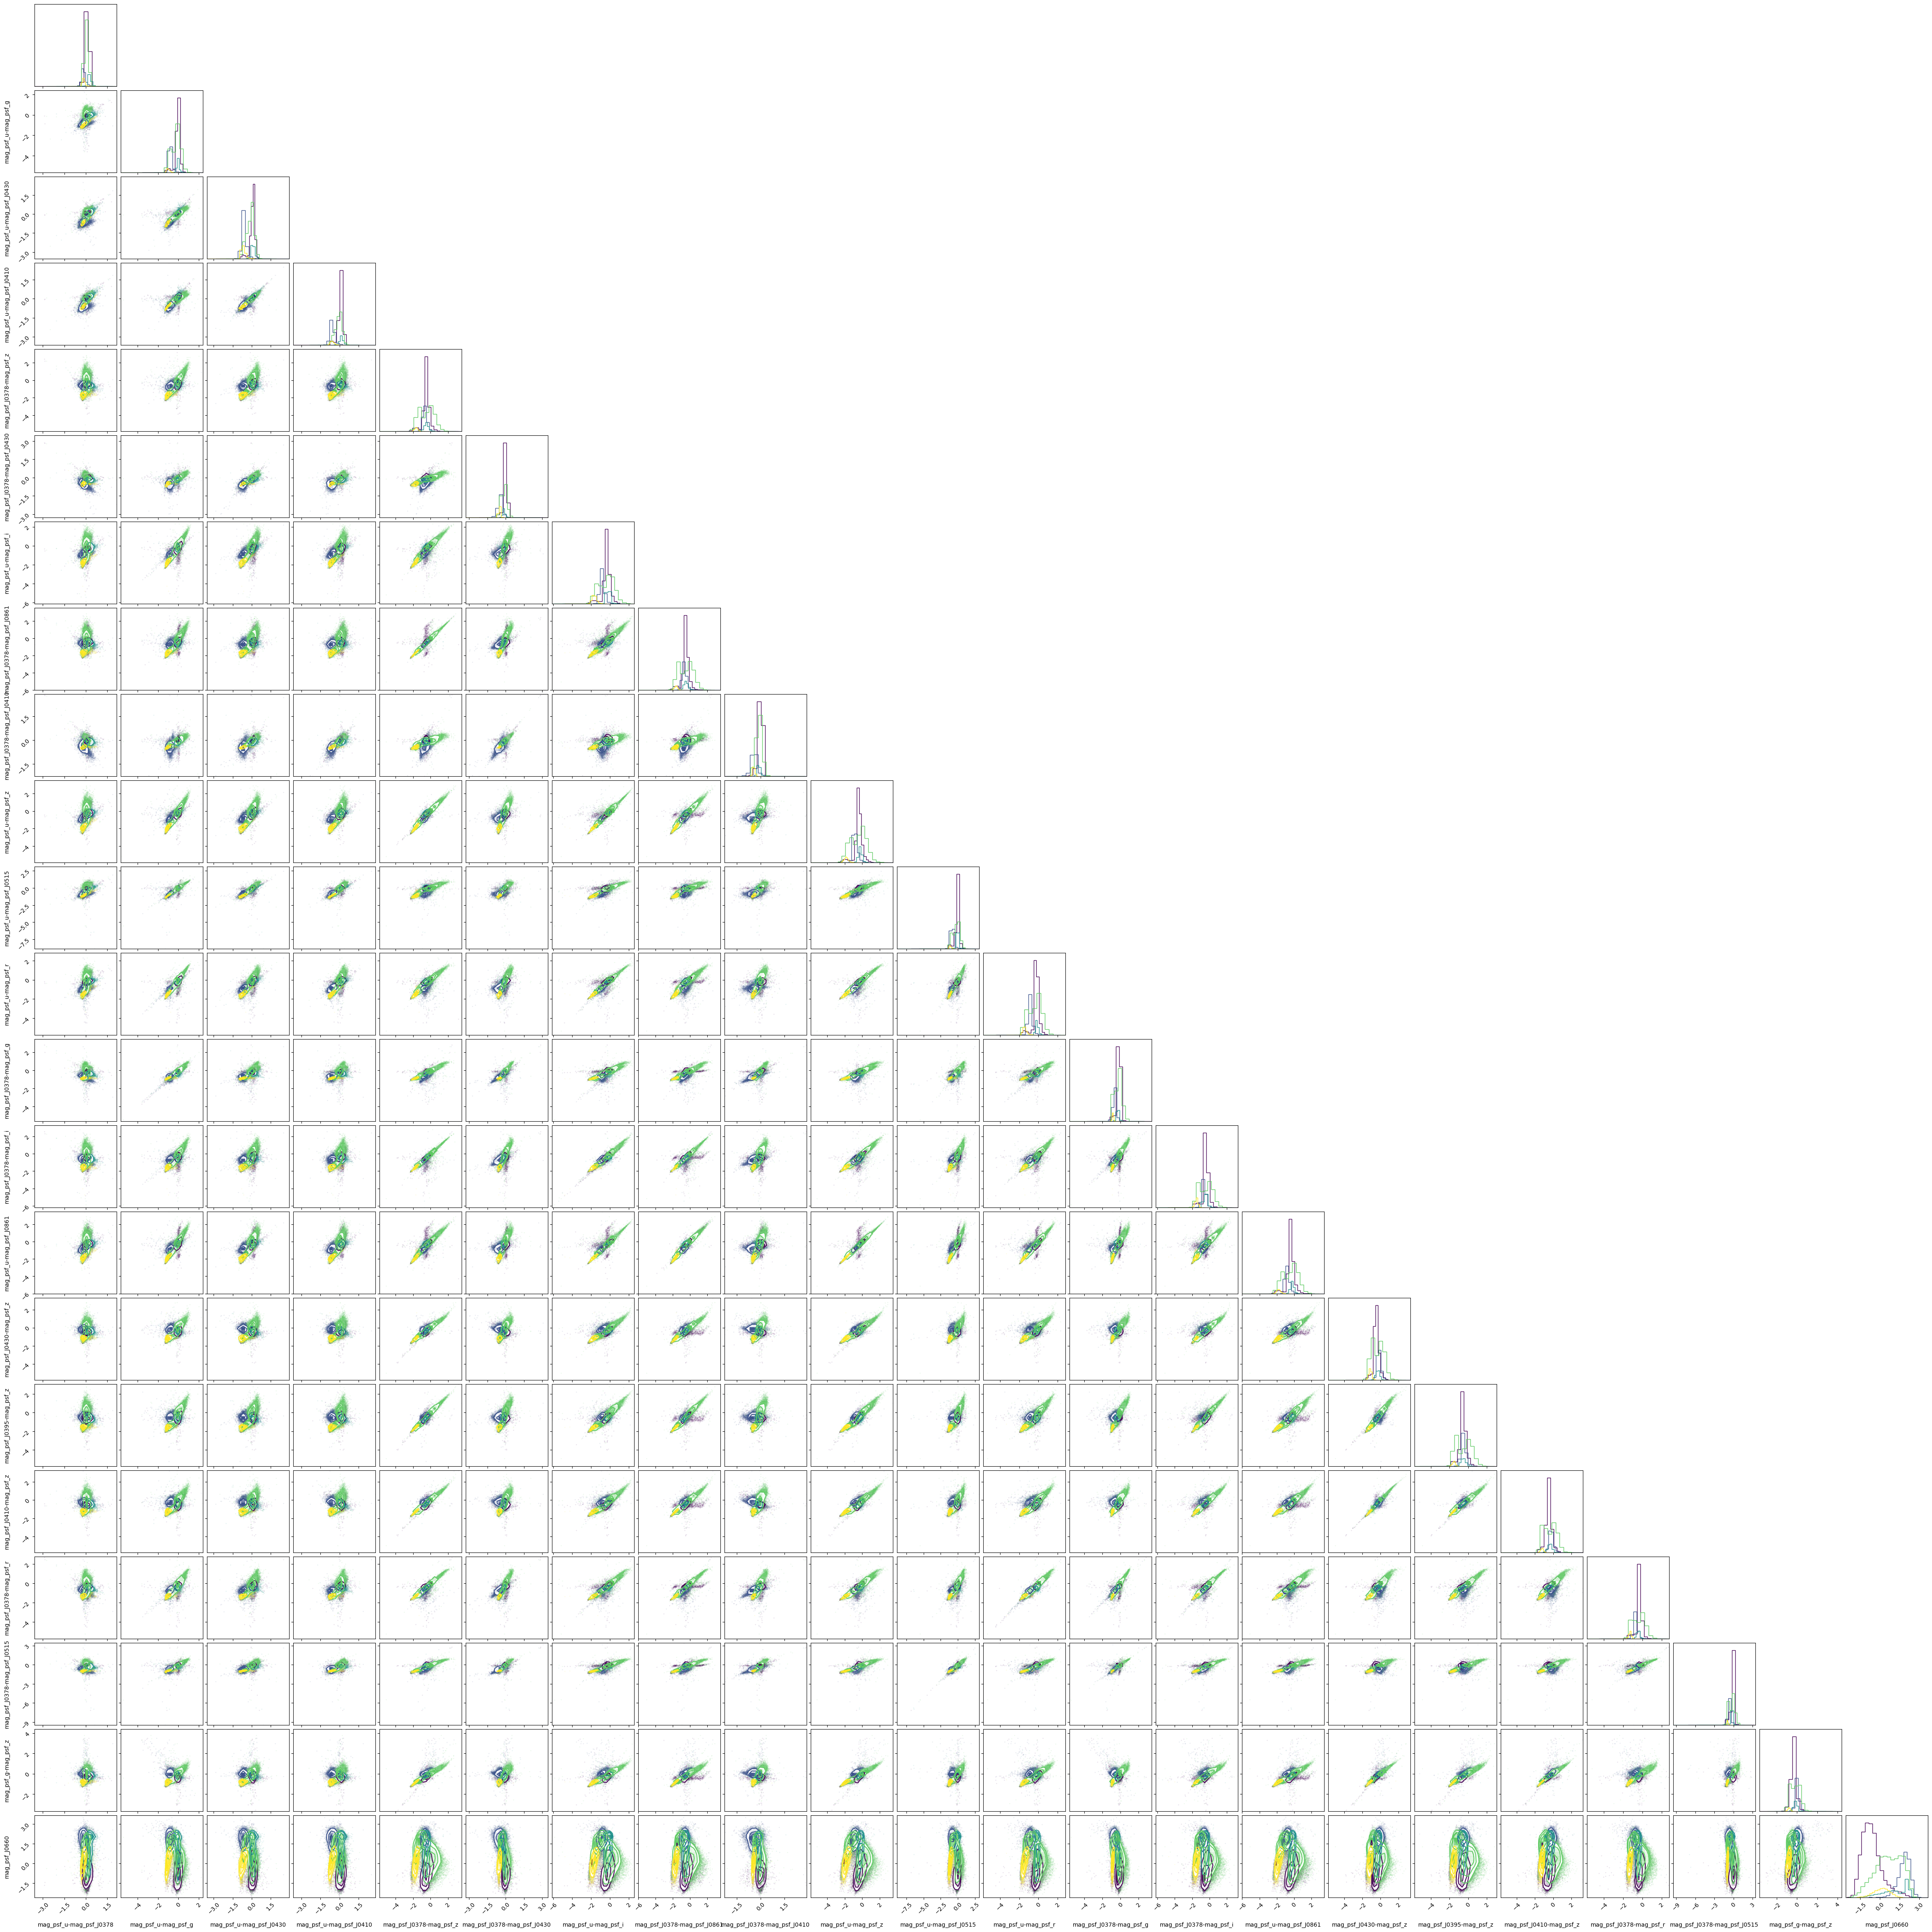

In [142]:
import corner
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Supongamos que tu DataFrame se llama df y la columna de etiquetas se llama "labels"
unique_labels = gaia_splus_predicted['best_class_name'].unique()

colors = plt.cm.viridis(np.linspace(0, 1, len(unique_labels)))
label_color_map = dict(zip(unique_labels, colors))

# Crea una figura
fig = None

# Itera sobre cada etiqueta única y crea un corner plot con un color específico
for label in unique_labels:
    subset = gaia_splus_predicted[gaia_splus_predicted['best_class_name'] == label]
    cols = subset[sorted_features.head(n_features)['0']].columns.tolist()
    data_for_plot = subset[list(sorted_features.head(n_features)['0'].values)]
    fig = corner.corner(data_for_plot, labels=cols,
                        color=label_color_map[label],  # Elige un colormap apropiado aquí
                        fig=fig)

plt.savefig('corner_plot_most_important_VS.pdf')

In [155]:
ls ../../SplusResult/

best_parameters.csv                graph_for_paper.pdf
Confusion_matrix.pdf               pair_plot_most_important_VS.pdf
corner_plot_most_important_VS.pdf  sorted_features.csv
df_score_results.csv


In [2]:
df = pd.read_csv('Gaia_splus_skiff_simbad.csv')

/tmp/ipykernel_5342/2646309333.py:1: DtypeWarning: Columns (63,66,68,71,74) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Gaia_splus_skiff_simbad.csv')


In [3]:
def classify_variable_star(category):
    # Eclipsantes
    eclipsantes = ['EA', 'EB', 'EW', 'EC', 'ESD|EC', 'EA|EB', 'EA|EW', 'EB|EW', 'EB:', 'EW:', 'EA:', 'EB+X', 'EW|EA', 'EC|ESD', 'ED|ESD', 'EC|DSCT|ESD', 'ESD|ED', 'EC|RRC|DSCT|ESD', 'EW|DSCT:', 'EC|DSCT', 'DSCT|EC', 'EC|RRC|ESD', 'ESD|DSCT|EC', 'EB/D', 'EC|RRC', 'ESD', 'EA/SD:', 'EA/SD', 'EA/D', 'EC|DCEP-FO|ESD', 'EW/RS', 'EW/KE', 'EA/RS', 'E', 'EA/DS:', 'EW/KW', 'EA/WD', 'EA/HW', 'EA/GS:', 'ED', 'E:']
    # Elipsoidales
    ell = ['ELL', 'ELL:']
    # RR Lyrae
    rrl = ['RR', 'RRAB', 'RRC', 'RRAB/BL', 'RR:', 'RRD', 'RRC:','RRAB|ESD|ED', 'EC|RRC|DSCT|ESD', 'EC|RRC', 'RRC|EC|ESD', 'RRD:', 'RRAB:', 'RRC|EC', 'RRC/BL']
    # Cefeidas
    cep = ['CEP', 'DCEP', 'ACEP', 'ACEP:', 'CEP:', 'ACEP|CEP', 'BCEP:']
    # Delta Scuti y pulsantes de corto periodo
    dsct = ['DSCT', 'DSCT:', 'DSCTC', 'EW|DSCT', 'EC|DSCT|ESD', 'DSCT|EC', 'ESD|DSCT|EC', 'SXPHE', 'HADS', 'HADS(B)', 'HADS:']
    # Estrellas con emisión o Eclipsantes
    estrellas_emision = ['HMXB', 'HMXB/XP','XPR', 'BE+HMXB/XP', 'HMXB/XP+GCAS', 'HMXB/XR+GCAS', 'HMXB/XP+LERI', 'HMXB/XPR:+GCAS', 'HMXB+E', 'EB+X', 'HMXB+GCAS', 'HMXB/XN+GCAS', 'GCAS', 'GCAS:', 'UGSS+EW', 'ACV', 'CV:', 'CWB', 'CWB:', 'IBWD']
    # Estilos AGN o Galaxias
    galaxias = ['AGN', 'QSO', 'BLLAC']
    # Rotación y Actividad Magnética
    rotacion_actividad_magnetica = ['ROT', 'BY', 'ACV','RS','RS:']
    # YSO y Asociados
    yso_asociados = ['YSO','TTS/ROT']

    if category in eclipsantes:
        return 'Eclipsantes'
    elif category in ell:
        return 'ELL'
    elif category in rrl:
        return 'RRL'
    elif category in cep:
        return 'CEP'
    elif category in dsct:
        return 'DSCT'
    elif category in estrellas_emision:
        return 'Estrellas con emisión o Eclipsantes'
    elif category in galaxias:
        return 'Galaxias'
    elif category in rotacion_actividad_magnetica:
        return 'Rotación y Actividad Magnética'
    elif category in yso_asociados:
        return 'YSO y Asociados'
    else:
        return 'Others'


In [4]:
classified_labels = [classify_variable_star(label) for label in df.loc[df['Type'].notna()]['Type']]
df.loc[df['Type'].notna(),'Class_VSX_nico_grouped'] = classified_labels

In [15]:
Vsx_con_gaia_splus = df.loc[(df["Class_VSX_nico_grouped"].notna())&(df["S_plus_prediction"].notna())]

In [25]:
Vsx_con_gaia_splus.loc[Vsx_con_gaia_splus['Class_VSX_nico_grouped']=='Eclipsantes']['S_plus_prediction']

3        BE|GCAS|SDOR|WR
4        BE|GCAS|SDOR|WR
5        BE|GCAS|SDOR|WR
119                  RRL
120                  RRL
              ...       
99735    DSCT|GDOR|SXPHE
99867    BE|GCAS|SDOR|WR
99898    BE|GCAS|SDOR|WR
99912    DSCT|GDOR|SXPHE
99914    BE|GCAS|SDOR|WR
Name: S_plus_prediction, Length: 5024, dtype: object

In [31]:
Vsx_con_gaia_splus.loc[(Vsx_con_gaia_splus['Class_VSX_nico_grouped']=='Eclipsantes')&
                        (Vsx_con_gaia_splus['S_plus_prediction']=='AGN')]

splus_oid_1                  #Field        Ra_1      Dec_1  IDRef  NMG  \
26656      9104315  SPLUS-n11s05_000012248  155.967804 -13.007030    910   12   
27595      8354575    SPLUS-d386_000005353  120.131111 -41.950977    718   12   
27598     10463841  SPLUS-s26s27_000005848   41.262207 -33.018646   1018   12   
27599     10128177  SPLUS-s23s08_000002434   11.017287 -29.866642   1013   12   
27601      8880167  SPLUS-n04n01_000003727  150.563171   3.834748    817   12   
27602      9271915  SPLUS-n13s02_000010425  151.957977 -16.234877    912   12   
27603       260336    HYDRA-0057_000004716  163.555038 -29.899551     13   12   
27604      6201244    SPLUS-d209_000007077  113.326767 -26.785000    518   12   
27609     10689957  SPLUS-s30s32_000003821   53.832531 -38.869404   1112   12   
27611      1182230    HYDRA-0140_000010916  155.008499 -43.594097    111   12   
27618      8019838    SPLUS-d324_000015989  123.957443 -36.130608    714   12   
27627     10780284  SPLUS-s32s38_000003687   66.338959 -41.353756   1114   12   
27629     10783861  SPLUS-s32s39_000010108   67.454735 -41.938103   1114   12   
27632     10783759  SPLUS-s32s39_000009523   68.314056 -41.076496   1114   12   
27633     10833449  SPLUS-s33s42_000004456   74.631393 -42.928757   1114   12   
27634     10782291  SPLUS-s32s39_000002256   68.703064 -41.860340   1114   12   
27638         5622    HYDRA-0011_000027559  149.958633 -24.560162     10   12   
27639       467037    HYDRA-0082_000022606  158.850632 -33.505630     15   12   
27641      9176287  SPLUS-n11s44_000015841  210.252380 -12.890659    911   12   
27645      3114801        MC0041_000283206   83.824715 -68.880585    218   12   
27649      8967228  SPLUS-n07s43_000000275  208.576752  -8.802545    818   12   
34230       678845    HYDRA-0105_000000764  154.515594 -38.423298     17   12   
34303      7368096    SPLUS-d263_000005897  126.732994 -31.343765    618   12   
34698      9250497  SPLUS-n12s37_000009889  200.994949 -14.840184    912   12   
62700      8893648  SPLUS-n04s44_000004255  209.640915  -4.017922    817   12   
65598      1082629    HYDRA-0134_000042119  160.804977 -41.476395    110   12   
65820     10625050  SPLUS-s28s47_000020841  314.825653 -35.726215   1111   12   
67864     10219479  SPLUS-s23s49_000004448  358.537231 -29.589943   1014   12   
68712      4827624        MC0114_000207975    7.386927 -73.859566    413   12   

       mag_psf_u  mag_psf_J0378  mag_psf_J0395  mag_psf_J0410  ...  Remarks  \
26656  -1.561318      -1.676195      -1.286520      -1.112047  ...      NaN   
27595  -1.673288      -1.572615      -1.489985      -1.248714  ...      NaN   
27598   0.575356       0.680484       0.822893       1.043508  ...      NaN   
27599  -0.822569      -0.683435      -0.494525      -0.193893  ...      NaN   
27601  -0.544765      -0.749124       0.615536       0.831430  ...      NaN   
27602  -0.880480      -0.843809      -0.717369       0.135184  ...      NaN   
27603   0.840261       0.871724       0.987618       1.087739  ...      NaN   
27604  -2.173417      -2.073000      -1.976641      -1.770752  ...      NaN   
27609  -0.253614      -0.118535       0.072168       0.128716  ...      NaN   
27611  -0.923068      -0.935438      -0.878394      -0.884725  ...      NaN   
27618  -2.417491      -2.315062      -2.287279      -2.050218  ...      NaN   
27627   0.669218       0.666730       0.745902       0.912368  ...      NaN   
27629  -1.460323      -1.417403      -1.227297      -0.932433  ...      NaN   
27632  -0.709009      -0.760391      -0.717733      -0.227177  ...      NaN   
27633   0.644297       0.734751       0.776614       1.033778  ...      NaN   
27634   0.238133       0.286226       0.397905       0.765944  ...      NaN   
27638  -0.799027      -0.648808      -0.521840       0.249642  ...      NaN   
27639   0.251615       0.409466       0.433486       0.427407  ...      NaN   
27641   1.319191       1.420088       1.543382       1.737468  ...      NaN